# Carga de librerías

In [ ]:
# Libraries not native to google colab
# %%capture
# !pip install comet_ml
# !pip install imageio

In [ ]:
# MUST RUN BEFORE TORCH
from comet_ml import Experiment

In [ ]:
# Para descargar pesos rápidamente
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import torch
import fnmatch
import torchvision
import numpy                  as np
import torch.nn               as nn
import matplotlib.pyplot      as plt
import torch.optim            as optim
import torchvision.transforms as transforms
from imageio          import imread
from getpass          import getpass
from torch.nn         import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision      import datasets, models, transforms

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Set same size for UNet and source images
# for convenience and GPU size limitations
SIZE = 128
IMG_SIZE = SIZE

In [ ]:
# Utils
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

# Modelo U-Net

In [ ]:
class Unet(nn.Module):

    # Implementación de U-Net obtenida del código de clases
    # Agradecimientos a Hae Yong Kim, Gabriel Garib y Domingo Mery
    # Agregada Batch Normalization

    def __init__(self, n, batch_size=10, chan_out=1, batchnorm=False):

        super().__init__()
        
        self.conv_1 = self.conv_layer(n, 0, batchnorm=batchnorm)
        self.conv_2 = self.conv_layer(n, 1, batchnorm=batchnorm)
        self.conv_3 = self.conv_layer(n, 2, batchnorm=batchnorm)
        self.conv_4 = self.conv_layer(n, 3, batchnorm=batchnorm)
        self.conv_5 = self.conv_layer(n, 4, batchnorm=batchnorm)
        self.conv_6 = self.conv_layer(n, 5, batchnorm=batchnorm)
        self.conv_7 = self.conv_layer(n, 6, batchnorm=batchnorm)
        self.conv_8 = self.conv_layer(n, 7, batchnorm=batchnorm)
        self.conv_9 = self.conv_layer(n, 8, batchnorm=batchnorm)

        self.conv_A = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=chan_out, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

        self.up_6 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_7 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_8 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_9 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

    @staticmethod    
    def conv_layer(n, l_n, batchnorm=False):
        if l_n == 0:
            in_  = 1
            out_ = n
        elif l_n < 5:
            in_  = int(n * (2 ** (l_n - 1)))
            out_ = int(n * (2 ** l_n))
        else:
            in_  = int(n * (2 ** (9 - l_n) ))
            out_ = int(n * (2 ** (9 - l_n - 1)))

        if batchnorm:
          # Agregamos BatchNorm despues de ReLU
          # evitamos vanishing gradients
          conv = nn.Sequential(
              nn.Conv2d(in_channels=in_, out_channels=out_, kernel_size=3, padding='same'),
              nn.ReLU(),
              nn.BatchNorm2d(out_),
              nn.Conv2d(in_channels=out_, out_channels=out_, kernel_size=3, padding='same'),
              nn.ReLU(),
              nn.BatchNorm2d(out_),
          )
        else:
          # Sin BatchNorm, código inicial del profesor
          conv = nn.Sequential(
              nn.Conv2d(in_channels=in_, out_channels=out_, kernel_size=3, padding='same'),
              nn.ReLU(),
              nn.Conv2d(in_channels=out_, out_channels=out_, kernel_size=3, padding='same'),
              nn.ReLU(),
          )
        return conv


    def forward(self, input_):
        conv_1 = self.conv_1(input_)
        pool_1 = nn.MaxPool2d(kernel_size=(2,2))(conv_1)

        conv_2 = self.conv_2(pool_1)
        pool_2 = nn.MaxPool2d(kernel_size=(2,2))(conv_2)

        conv_3 = self.conv_3(pool_2)
        pool_3 = nn.MaxPool2d(kernel_size=(2,2))(conv_3)

        conv_4 = self.conv_4(pool_3)
        pool_4 = nn.MaxPool2d(kernel_size=(2,2))(conv_4)

        conv_5 = self.conv_5(pool_4)

        up_6    = self.up_6(conv_5)
        merge_6 = torch.cat([conv_4, up_6], dim=1)
        conv_6  = self.conv_6(merge_6)

        up_7    = self.up_7(conv_6)
        merge_7 = torch.cat([conv_3, up_7], dim=1)
        conv_7  = self.conv_7(merge_7)

        up_8    = self.up_8(conv_7)
        merge_8 = torch.cat([conv_2, up_8], dim=1)
        conv_8  = self.conv_8(merge_8)

        up_9    = self.up_9(conv_8)
        merge_9 = torch.cat([conv_1, up_9], dim=1)
        conv_9  = self.conv_9(merge_9)

        return self.conv_A(conv_9)

# Funciones de entrenamiento y logging

In [ ]:
class BCELoss2d(nn.Module):
  # Calcula Binary Cross Entropy para un mapa 2D
  # Fuente: https://github.com/hiyouga/Image-Segmentation-PyTorch/blob/master/loss_func.py
  def __init__(self):
    super(BCELoss2d, self).__init__()
    self.bce_loss = nn.BCELoss()
    
  def forward(self, predict, target):
    predict = predict.view(-1)
    target = target.view(-1)
    return self.bce_loss(predict, target)

class BCELoss3d(nn.Module):
  # Similar a anterior pero calcula BCE loss para clases por separado
  def __init__(self, classes):
    super(BCELoss3d, self).__init__()
    self.bce_loss = nn.BCELoss()
    self.classes = classes
    
  def forward(self, predict, target):
    loss = 0.
    for x in range(self.classes):
      loss += self.bce_loss(predict[:, x, :, :].flatten(), target[:, x, :, :].flatten())
    return loss / self.classes

def dice_loss(input, target):
  # Dice Loss normal para caso de una clase única
  # También funciona multiclase, pero no considera clases separadas
  # Fuente: https://github.com/pytorch/pytorch/issues/1249
  smooth = 1.

  iflat = input.view(-1)
  tflat = target.view(-1)
  intersection = (iflat * tflat).sum()
    
  return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))
  
def log_cosh_dice_loss(input, target):
  return torch.log(torch.cosh(dice_loss(input, target)))

In [ ]:
def train_epoch(model, iterator, optimizer, criterion, device, experiment, e):
  # Código usual para entrenar una época
  # Agregamos código para logging de pérdidas
  epoch_loss = 0
  model.train()
  for batch in iterator:
    optimizer.zero_grad()

    img, seg = batch
    img = img.to(device)
    seg = seg.to(device)

    predictions = model(img)

    loss = criterion(predictions, seg)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  if experiment is not None:
    # Usamos COMET para logging de pérdidas
    experiment.log_metric("train_loss", epoch_loss / len(iterator), step=e)
    
  return epoch_loss/len(iterator)


def eval_epoch(model, iterator, criterion, device, experiment, e):

  #initialize every epoch
  epoch_loss = 0

  #deactivating dropout layers
  model.eval()

  #deactivates autograd
  with torch.no_grad():
    for batch in iterator:
        
      img, seg = batch
      img = img.to(device)
      seg = seg.to(device)
            
      #convert to 1d tensor
      predictions = model(img)
            
      #compute loss
      loss = criterion(predictions, seg)
            
      #keep track of loss
      epoch_loss += loss.item()

  if experiment is not None:
    # Usamos COMET para logging de pérdidas
    experiment.log_metric("val_loss", epoch_loss / len(iterator), step=e)
        
  return epoch_loss / len(iterator)

In [ ]:
def train_epochs(model, data, criterion, optimizer, device, epochs, experiment, name, early=10):
  # Función que dado un modelo lo entrena N épocas
  # También se encarga de logging usando Comet
  best_val = float("Inf")

  data_train, data_val = data
  early_stop = 0

  for epoch in range(epochs):
  
    # Training
    train_loss = train_epoch(model, data_train, optimizer, criterion, device, experiment, epoch)

    # Validation
    val_loss = eval_epoch(model, data_val, criterion, device, experiment, epoch)

    st = f'Training Loss: {train_loss:.4f}'
    sv = f'Validation Loss: {val_loss:.4f}'
    print('['+num2fixstr(epoch+1,3)+'/'+num2fixstr(epochs,3)+'] ' + st + ' | '+sv)

    if val_loss < best_val:
      # Guardamos el modelo con mejor pérdida en validación
      print(f"Best model achieved, saving to {name}.pth")
      torch.save(model.state_dict(), f"{name}.pth")
      best_val = val_loss
      early_stop = 0
    else:
      early_stop += 1
      if early_stop >= early:
        print(f"Early model stop. Best validation loss: {best_val}")
        break


In [ ]:
def define_train_unet(data, batch_size, device, name, epochs=150, pretrained=None, n=SIZE, 
                      loss="MSE", optimizer="Adam", lr=1e-4, experiment=False, bn=False, 
                      early=10, chan_out=1):
  exp = None
  if experiment:
    # Log experiment to COMET
    exp = Experiment(
      api_key      = getpass(prompt='Key: '), # Secret
      project_name = "",
      workspace    = "",
    )

    # Parameters to log
    params = {
        "Model Size": n,
        "epochs": epochs,
        "loss": loss,
        "optimizer": optimizer,
        "learning rate": lr,
        "name": name
    }

    exp.log_parameters(params)

  if pretrained is not None:
    # Continuamos entrenando un modelo preentrenado
    model = pretrained
  else:
    # Instanciamos el modelo de UNet
    model = Unet(n, batchnorm=bn, chan_out=chan_out).to(device)

  # Probar con otras pérdidas
  if loss == "MSE":
    criterion = nn.MSELoss().to(device)
  elif loss == "CrossEntropy":
    criterion = BCELoss2d().to(device)
  elif loss == "Dice":
    criterion = dice_loss
  elif loss == "CrossEntropy_all":
    criterion = BCELoss3d(classes=3).to(device)
  elif loss == "log_cosh":
    criterion = log_cosh_dice_loss
  else:
    raise NotImplementedError(f"Loss not implemented: {loss}")

  # Distintos optimizadores
  if optimizer == "Adam":
    opti = optim.Adam(model.parameters(), lr=lr)
  else:
    raise NotImplementedError(f"Optimizer not implemented: {optimizer}")

  try:
    # Entrenamos el modelo
    train_epochs(model, data, criterion, opti, device, epochs, exp, name, early=early)
  except KeyboardInterrupt:
    if experiment:
      exp.end()

  if experiment:
    # End current experiment
    exp.end()

  return model

# Carga de datos

In [ ]:
!wget -q # Add JSRT Dataset link
!wget -q # Add SCR Dataset link

In [ ]:
!unzip -qo JSRT.zip
!unzip -qo SCR.zip

All247images/JPCLN122.IMG  bad CRC 117dc0ee  (should be e42d91b6)


## Funciones de carga de imágenes

In [ ]:
def dirfiles(img_path, img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names

def load_images(fpath, img_names, echo='off', nl=IMG_SIZE, nc=IMG_SIZE):
  # Cargamos las imágenes y las dejamos en un diccionario
  images = {}
  for name in img_names:
    st = fpath + os.sep + name
    # Extraemos las imágenes de tipo .IMG
    # https://forum.image.sc/t/how-to-open-the-images-from-jsrt-database-in-imagej/11317/7
    X = np.fromfile(st, dtype=">i2").reshape((2048, 2048)).astype('uint16')/65535.0
    X = cv2.resize(X, (nl, nc))
    # plt.imshow(X, cmap="gray")
    X = X.astype(np.double)
    images[name.split('.')[0]] = X
  return images

files  = dirfiles("All247images", "*.IMG")
images = load_images("All247images", files)

## Funciones de carga de Máscaras

In [ ]:
def load_combine_masks(fpath, middle, first_mask, second_mask, mask_dict, size=SIZE):
  files1 = f"{fpath}{os.sep}{middle}{os.sep}masks{os.sep}{first_mask}"
  files2 = f"{fpath}{os.sep}{middle}{os.sep}masks{os.sep}{second_mask}"

  names = dirfiles(files1, "*.gif")

  for name in names:
    # Tomamos ambas máscaras y las combinamos
    img1 = imread(files1 + os.sep + name)
    img1 = cv2.resize(img1, (size, size)) / 255
    img2 = imread(files2 + os.sep + name)
    img2 = cv2.resize(img2, (size, size)) / 255
    mask = np.maximum(img1, img2)
    mask_dict[name.split('.')[0]] = mask

def load_masks(fpath, test=False, mask_type="heart", size=SIZE):
  # Carga las máscaras de corazón o pulmónes
  masks = {}

  if test:
    # Carpeta de testing
    middle = "fold2"
  else:
    # Carpeta de training
    middle = "fold1"

  if mask_type == "lung":
    # Máscaras de ambos pulmones
    load_combine_masks(fpath, middle, "left lung", "right lung", masks)

  elif mask_type == "clavicle":
    # Máscaras de ambas clavículas
    load_combine_masks(fpath, middle, "left clavicle", "right clavicle", masks)

  else:
    # Buscamos las máscaras
    files  = f"{fpath}{os.sep}{middle}{os.sep}masks{os.sep}heart"
    names = dirfiles(files, "*.gif")

    for name in names:
      # Dejamos en el tamaño necesario y guardamos
      img = imread(files + os.sep + name)
      img = cv2.resize(img, (size, size)) / 255
      masks[name.split('.')[0]] = img

  return masks

## Dataset de Pytorch

In [ ]:
def trans(data):
  # Helper function
  return torch.unsqueeze(torch.from_numpy(data), dim=0).float()

def trans_(data):
  # Helper function
  return torch.from_numpy(data).float()

In [ ]:
class JSRTDataset(Dataset):

  def __init__(self, images, test=False, mask="heart"):
    super().__init__()
    # Extraemos las máscaras necesarias
    # Asumimos que las imágenes se encuentran extraídas
    self.mask = mask

    if self.mask in ["heart", "all"]:
      heart_masks = load_masks("scratch", test=test)

    if self.mask in ["clavicles", "all"]:
      clav_masks = load_masks("scratch", mask_type="clavicle", test=test)

    if self.mask in ["lungs", "all"]:
      lung_masks  = load_masks("scratch", mask_type="lung", test=test)

    self.data = []

    if self.mask == "heart":
      self.add_data(images, heart_masks)
    elif self.mask == "clavicles":
      self.add_data(images, clav_masks)
    elif self.mask == "lungs":
      self.add_data(images, lung_masks)
    elif self.mask == "all":
      for img_name in heart_masks:
        mask_channels = [lung_masks[img_name], heart_masks[img_name], clav_masks[img_name]]
        mask_channels = [torch.from_numpy(ma).float() for ma in mask_channels]
        self.data.append((trans(images[img_name]), torch.stack(mask_channels)))

  def add_data(self, images, masks):
    for img_name in masks:
      self.data.append((trans(images[img_name]), trans(masks[img_name])))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, n):
    # Hacemos unsqueeze ya que sólo tenemos un canal de brillo
    # Float debido a que el modelo es float y los datos deben serlo
    item = self.data[n]
    return item[0], item[1]


## Obtención de métricas

In [ ]:
def get_precision_recall(data, model):

  TP = 0
  FP = 0
  FN = 0

  model.eval()

  #deactivates autograd
  with torch.no_grad():
    for batch in data:
        
      img, seg = batch
      img = img.to(device)
            
      #convert to 1d tensor
      predictions = (model(img).cpu().detach().numpy() > 0.5)*1
      seg = seg.cpu().detach().numpy()

      # Obtenemos y sumamos TP, FP y FN para todas las imágenes del batch

      TP += np.sum(np.multiply(predictions==1,seg==1))
      FP += np.sum(np.multiply(predictions==1,seg==0))
      FN += np.sum(np.multiply(predictions==0,seg==1))
  print(f"TP: {TP}, FP: {FP}, FN: {FN}")
  # Dados los TP, FP y FN totales obtenemos
  # Precision, Recall y F1-Score
  Pr = TP/(TP+FP)
  Re = TP/(TP+FN)
  F1 = 2 * (Pr * Re) / (Pr + Re)

  print('Testing:')
  print(f'Precision   = {Pr:.4f}')
  print(f'Recall      = {Re:.4f}')
  print(f'F1 Score    = {F1:.4f}')

In [ ]:
def get_precision_recall_multiclass(data, model, classes=3):

  TP = np.zeros((classes))
  FP = np.zeros((classes))
  FN = np.zeros((classes))

  model.eval()

  #deactivates autograd
  with torch.no_grad():
    for batch in data:
        
      img, seg = batch
      img = img.to(device)
            
      #convert to 1d tensor
      predictions = (model(img).cpu().detach().numpy() > 0.5)*1
      seg = seg.cpu().detach().numpy()

      # Obtenemos y sumamos TP, FP y FN para todas las imágenes del batch

      TP += np.sum(np.multiply(predictions==1,seg==1), axis=(0, 2, 3))
      FP += np.sum(np.multiply(predictions==1,seg==0), axis=(0, 2, 3))
      FN += np.sum(np.multiply(predictions==0,seg==1), axis=(0, 2, 3))

  # Dados los TP, FP y FN totales obtenemos
  # Precision, Recall y F1-Score
  Pr = TP/(TP+FP)
  Re = TP/(TP+FN)
  F1 = 2 * (Pr * Re) / (Pr + Re)

  # Macro stats
  mPr = np.mean(Pr)
  mRe = np.mean(Re)
  mF1 = 2 * (mPr * mRe) / (mPr + mRe)

  # Micro stats
  TP_t = np.sum(TP)
  FP_t = np.sum(FP)
  FN_t = np.sum(FN)

  miPr = TP_t/(TP_t+FP_t)
  miRe = TP_t/(TP_t+FN_t)
  miF1 = 2 * (miPr * miRe) / (miPr + miRe)

  print(f"Class Precisions: \nPulmones {Pr[0]:.4f}\t\tCorazón {Pr[1]:.4f}\t\tClavícula {Pr[2]:.4f}")
  print(f"Class Recalls: \nPulmones {Re[0]:.4f}\t\tCorazón {Re[1]:.4f}\t\tClavícula {Re[2]:.4f}")
  print(f"Class F1: \nPulmones {F1[0]:.4f}\t\tCorazón {F1[1]:.4f}\t\tClavícula {F1[2]:.4f}")

  print(f"\nPrecision (micro): {miPr:.4f}")
  print(f"Recall (micro): {miRe:.4f}")
  print(f"F1 (micro): {miF1:.4f}")

  print(f"\nPrecision (macro): {mPr:.4f}")
  print(f"Recall (macro): {mRe:.4f}")
  print(f"F1 (macro): {mF1:.4f}")

## DataLoader Corazón

In [ ]:
BATCH_SIZE = 5

# Test y train dataset
test_set_heart  = JSRTDataset(images, test=True, mask="heart")
train_set_heart = JSRTDataset(images, test=False, mask="heart")

# Creamos DataLoaders
testloader_heart  = DataLoader(dataset=test_set_heart, batch_size=BATCH_SIZE, shuffle=True)
trainloader_heart = DataLoader(dataset=train_set_heart, batch_size=BATCH_SIZE, shuffle=True)

## DataLoader Pulmones

In [ ]:
BATCH_SIZE = 5

# Test y train dataset
test_set_lungs  = JSRTDataset(images, test=True, mask="lungs")
train_set_lungs = JSRTDataset(images, test=False, mask="lungs")

# Creamos DataLoaders
testloader_lungs  = DataLoader(dataset=test_set_lungs, batch_size=BATCH_SIZE, shuffle=True)
trainloader_lungs = DataLoader(dataset=train_set_lungs, batch_size=BATCH_SIZE, shuffle=True)

## DataLoader Clavículas

In [ ]:
BATCH_SIZE = 5

# Test y train dataset
test_set_clav  = JSRTDataset(images, test=True, mask="clavicles")
train_set_clav = JSRTDataset(images, test=False, mask="clavicles")

# Creamos DataLoaders
testloader_clav  = DataLoader(dataset=test_set_clav, batch_size=BATCH_SIZE, shuffle=True)
trainloader_clav = DataLoader(dataset=train_set_clav, batch_size=BATCH_SIZE, shuffle=True)

## Dataloader Multiclase

In [ ]:
BATCH_SIZE = 5

# Test y train dataset
test_set_all  = JSRTDataset(images, test=True, mask="all")
train_set_all = JSRTDataset(images, test=False, mask="all")

# Creamos DataLoaders
testloader_all  = DataLoader(dataset=test_set_all, batch_size=BATCH_SIZE, shuffle=True)
trainloader_all = DataLoader(dataset=train_set_all, batch_size=BATCH_SIZE, shuffle=True)

# Entrenamiento

Esta sección del código muestra donde corrimos nuestros diferentes experimentos.

## Corazón sin BatchNorm

In [ ]:
# MSE LOSS
data = (trainloader_heart, testloader_heart)

model = define_train_unet(data, BATCH_SIZE, device, "heart-UNet_v0", experiment=True, bn=False)

## Corazón usando BatchNorm

### MSE Error

In [ ]:
# MSE LOSS
data = (trainloader_heart, testloader_heart)

model = define_train_unet(data, BATCH_SIZE, device, "heart-UNet_v1", experiment=True, bn=True)

### Binary Cross-Entropy 2D Error

In [ ]:
# BCE 2D LOSS
data = (trainloader_heart, testloader_heart)

model = define_train_unet(data, BATCH_SIZE, device, "heart-UNet_v2", loss="CrossEntropy", experiment=True, bn=True)

### Dice Loss

In [ ]:
# Dice LOSS
data = (trainloader_heart, testloader_heart)

model = define_train_unet(data, BATCH_SIZE, device, "heart-UNet_v3", loss="Dice", experiment=True, bn=True)

## Pulmones sin BatchNorm

In [ ]:
# MSE LOSS
data = (trainloader_lungs, testloader_lungs)

model = define_train_unet(data, BATCH_SIZE, device, "lungs-UNet_v0", experiment=True, bn=False)

## Pulmones usando BatchNorm

### MSE Error

In [ ]:
# MSE LOSS
data = (trainloader_lungs, testloader_lungs)

model = define_train_unet(data, BATCH_SIZE, device, "lungs-UNet_v1", experiment=True, bn=True)

### Binary Cross-Entropy 2D Error

In [ ]:
# BCE 2D LOSS
data = (trainloader_lungs, testloader_lungs)

model = define_train_unet(data, BATCH_SIZE, device, "lungs-UNet_v2", loss="CrossEntropy", experiment=True, bn=True)

### Dice Loss

In [ ]:
# Dice LOSS
data = (trainloader_lungs, testloader_lungs)

model = define_train_unet(data, BATCH_SIZE, device, "lungs-UNet_v3", loss="Dice", experiment=True, bn=True)

## Clavículas usando BatchNorm

### MSE Loss

In [ ]:
# MSE LOSS
data = (trainloader_clav, testloader_clav)

model = define_train_unet(data, BATCH_SIZE, device, "clavicle-UNet_v0", experiment=True, bn=True)

### Binary Cross-Entropy 2D Loss

In [ ]:
# Binary Cross-Entropy 2D LOSS
data = (trainloader_clav, testloader_clav)

model = define_train_unet(data, BATCH_SIZE, device, "clavicle-UNet_v1", loss="CrossEntropy", experiment=True, bn=True)

### Dice Loss

In [ ]:
# Dice LOSS
data = (trainloader_clav, testloader_clav)

model = define_train_unet(data, BATCH_SIZE, device, "clavicle-UNet_v2", loss="Dice", experiment=True, bn=True)

## Multiclase usando BatchNorn

### MSE Loss

In [ ]:
# MSE LOSS
data = (trainloader_all, testloader_all)

model = define_train_unet(data, BATCH_SIZE, device, "all-UNet_v0", experiment=True, bn=True, chan_out=3)

### BCE Loss 2D

In [ ]:
# BCE LOSS 2D
data = (trainloader_all, testloader_all)

model = define_train_unet(data, BATCH_SIZE, device, "all-UNet_v1", experiment=True, loss="CrossEntropy", bn=True, chan_out=3)

### Dice Loss (2D)

In [ ]:
# Dice Loss 2D
data = (trainloader_all, testloader_all)

model = define_train_unet(data, BATCH_SIZE, device, "all-UNet_v2", experiment=True, loss="Dice", bn=True, chan_out=3)

### BCE Loss (3D)

In [ ]:
# Dice Loss 2D
data = (trainloader_all, testloader_all)

model = define_train_unet(data, BATCH_SIZE, device, "all-UNet_v3", experiment=True, loss="CrossEntropy_all", bn=True, chan_out=3)

### Log-Cosh Dice Loss

In [ ]:
# Log-Cosh Dice Loss
data = (trainloader_all, testloader_all)

model = define_train_unet(data, BATCH_SIZE, device, "all-UNet_v4", experiment=True, loss="log_cosh", bn=True, chan_out=3)

# Prueba y Obtención de Métricas

## Carga de Modelos

### Modelos corazón

In [ ]:
# Cargamos los pesos obtenidos en el mejor modelo
# Debido a restricciones de Dropbox, usamos datos desde Drive
heart_path_v0 = "heart-UNet_v0.pth"
# Modelo corazón, sin BatchNorm, pérdida MSE

model_heart_v0 = Unet(SIZE, batchnorm=False).to(device)

model_heart_v0.load_state_dict(torch.load(heart_path_v0))

<All keys matched successfully>

In [ ]:
heart_path_v1 = "heart-UNet_v1.pth"
# Modelo corazón, con BatchNorm, pérdida MSE

model_heart_v1 = Unet(SIZE, batchnorm=True).to(device)

model_heart_v1.load_state_dict(torch.load(heart_path_v1))

<All keys matched successfully>

In [ ]:
heart_path_v2 = "heart-UNet_v2.pth"
# Modelo corazón, con BatchNorm, pérdida BCE

model_heart_v2 = Unet(SIZE, batchnorm=True).to(device)

model_heart_v2.load_state_dict(torch.load(heart_path_v2))

<All keys matched successfully>

In [ ]:
heart_path_v3 = "heart-UNet_v3.pth"
# Modelo corazón, con BatchNorm, pérdida Dice

model_heart_v3 = Unet(SIZE, batchnorm=True).to(device)

model_heart_v3.load_state_dict(torch.load(heart_path_v3))

<All keys matched successfully>

### Modelos pulmones

In [ ]:
# Cargamos los pesos obtenidos en el mejor modelo
# Debido a restricciones de Dropbox, usamos datos desde Drive
lungs_path_v0 = "lungs-UNet_v0.pth"
# Modelo pulmones, sin BatchNorm, pérdida MSE

model_lungs_v0 = Unet(SIZE, batchnorm=False).to(device)

model_lungs_v0.load_state_dict(torch.load(lungs_path_v0))

<All keys matched successfully>

In [ ]:
lungs_path_v1 = "lungs-UNet_v1.pth"
# Modelo pulmones, con BatchNorm, pérdida MSE

model_lungs_v1 = Unet(SIZE, batchnorm=True).to(device)

model_lungs_v1.load_state_dict(torch.load(lungs_path_v1))

<All keys matched successfully>

In [ ]:
lungs_path_v2 = "lungs-UNet_v2.pth"
# Modelo pulmones, con BatchNorm, pérdida BCE

model_lungs_v2 = Unet(SIZE, batchnorm=True).to(device)

model_lungs_v2.load_state_dict(torch.load(lungs_path_v2))

<All keys matched successfully>

In [ ]:
lungs_path_v3 = "lungs-UNet_v3.pth"
# Modelo pulmones, con BatchNorm, pérdida Dice

model_lungs_v3 = Unet(SIZE, batchnorm=True).to(device)

model_lungs_v3.load_state_dict(torch.load(lungs_path_v3))

<All keys matched successfully>

### Modelos clavículas

In [ ]:
clav_path_v0 = "clavicle-UNet_v0.pth"

model_clav_v0 = Unet(SIZE, batchnorm=True).to(device)
# Modelo clavículas, con BatchNorm, pérdida MSE

model_clav_v0.load_state_dict(torch.load(clav_path_v0))

<All keys matched successfully>

In [ ]:
clav_path_v1 = "clavicle-UNet_v1.pth"

model_clav_v1 = Unet(SIZE, batchnorm=True).to(device)
# Modelo clavículas, con BatchNorm, pérdida Binary Cross-Entropy 2D

model_clav_v1.load_state_dict(torch.load(clav_path_v1))

<All keys matched successfully>

In [ ]:
clav_path_v2 = "clavicle-UNet_v2.pth"

model_clav_v2 = Unet(SIZE, batchnorm=True).to(device)
# Modelo clavículas, con BatchNorm, pérdida Dice

model_clav_v2.load_state_dict(torch.load(clav_path_v2))

<All keys matched successfully>

### Modelo Multiclase

In [ ]:
all_path_v0 = "all-UNet_v0.pth"

model_all_v0 = Unet(SIZE, batchnorm=True, chan_out=3).to(device)
# Modelo multiclase, con BatchNorm, pérdida MSE

model_all_v0.load_state_dict(torch.load(all_path_v0))

<All keys matched successfully>

In [ ]:
all_path_v1 = "all-UNet_v1.pth"

model_all_v1 = Unet(SIZE, batchnorm=True, chan_out=3).to(device)
# Modelo multiclase, con BatchNorm, pérdida CrossEntropy

model_all_v1.load_state_dict(torch.load(all_path_v1))

<All keys matched successfully>

In [ ]:
all_path_v2 = "all-UNet_v2.pth"

model_all_v2 = Unet(SIZE, batchnorm=True, chan_out=3).to(device)
# Modelo multiclase, con BatchNorm, pérdida Dice

model_all_v2.load_state_dict(torch.load(all_path_v2))

<All keys matched successfully>

In [ ]:
all_path_v3 = "all-UNet_v3.pth"

model_all_v3 = Unet(SIZE, batchnorm=True, chan_out=3).to(device)
# Modelo multiclase, con BatchNorm, pérdida BCE con varias clases

model_all_v3.load_state_dict(torch.load(all_path_v3))

<All keys matched successfully>

In [ ]:
all_path_v4 = "all-UNet_v4.pth"

model_all_v4 = Unet(SIZE, batchnorm=True, chan_out=3).to(device)
# Modelo multiclase, con BatchNorm, pérdida Dice 3D

model_all_v4.load_state_dict(torch.load(all_path_v4))

<All keys matched successfully>

## Obtener métricas

### Corazón s/BatchNorm

Pérdida MSE

In [ ]:
# Obtenenos métricas modelo sin BatchNorm en Corazón
# Podemos ver que modelo predice máscara vacía
# Precision y F1 son NaN
get_precision_recall(testloader_heart, model_heart_v0)

TP: 0, FP: 0, FN: 179491
Testing:
Precision   = nan
Recall      = 0.0000
F1 Score    = nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning:

invalid value encountered in long_scalars



### Corazón c/BatchNorm

Pérdida MSE

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Corazón
get_precision_recall(testloader_heart, model_heart_v1)

Testing:
Precision   = 0.9566
Recall      = 0.9368
F1 Score    = 0.9466


Pérdida BCE 2D

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Corazón
get_precision_recall(testloader_heart, model_heart_v2)

TP: 164950, FP: 6605, FN: 14541
Testing:
Precision   = 0.9615
Recall      = 0.9190
F1 Score    = 0.9398


Pérdida Dice

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Corazón
get_precision_recall(testloader_heart, model_heart_v3)

TP: 170815, FP: 9889, FN: 8676
Testing:
Precision   = 0.9453
Recall      = 0.9517
F1 Score    = 0.9485


### Pulmones s/BatchNorm

Pérdida MSE

In [ ]:
# Obtenenos métricas modelo sin BatchNorm en Pulmones
get_precision_recall(testloader_lungs, model_lungs_v0)

TP: 583772, FP: 21321, FN: 28289
Testing:
Precision   = 0.9648
Recall      = 0.9538
F1 Score    = 0.9592


### Pulmones c/BatchNorm

Pérdida MSE

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Pulmones
get_precision_recall(testloader_lungs, model_lungs_v1)

TP: 599911, FP: 9710, FN: 12150
Testing:
Precision   = 0.9841
Recall      = 0.9801
F1 Score    = 0.9821


Pérdida BCE 2D

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Pulmones
get_precision_recall(testloader_lungs, model_lungs_v2)

TP: 598192, FP: 8844, FN: 13869
Testing:
Precision   = 0.9854
Recall      = 0.9773
F1 Score    = 0.9814


Pérdida Dice

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Pulmones
get_precision_recall(testloader_lungs, model_lungs_v3)

TP: 600194, FP: 8957, FN: 11867
Testing:
Precision   = 0.9853
Recall      = 0.9806
F1 Score    = 0.9829


### Clavículas c/BatchNorm

Pérdida MSE

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Clavículas
get_precision_recall(testloader_clav, model_clav_v0)

TP: 34757, FP: 10337, FN: 2812
Testing:
Precision   = 0.7708
Recall      = 0.9252
F1 Score    = 0.8409


Pérdida BCE 2D

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Clavículas
get_precision_recall(testloader_clav, model_clav_v1)

TP: 33882, FP: 2614, FN: 3687
Testing:
Precision   = 0.9284
Recall      = 0.9019
F1 Score    = 0.9149


Pérdida Dice

In [ ]:
# Obtenenos métricas modelo con BatchNorm en Clavículas
get_precision_recall(testloader_clav, model_clav_v2)

TP: 34425, FP: 2922, FN: 3144
Testing:
Precision   = 0.9218
Recall      = 0.9163
F1 Score    = 0.9190


### Multiclase

MSE

In [ ]:
get_precision_recall_multiclass(testloader_all, model_all_v0)

Class Precisions: 
Pulmones 0.9843		Corazón 0.9391		Clavícula 0.7764
Class Recalls: 
Pulmones 0.9780		Corazón 0.9509		Clavícula 0.9340
Class F1: 
Pulmones 0.9812		Corazón 0.9449		Clavícula 0.8479

Precision (micro): 0.9632
Recall (micro): 0.9702
F1 (micro): 0.9667

Precision (macro): 0.8999
Recall (macro): 0.9543
F1 (macro): 0.9263


In [ ]:
get_precision_recall_multiclass(testloader_all, model_all_v1)

Class Precisions: 
Pulmones 0.9780		Corazón 0.9728		Clavícula 0.9049
Class Recalls: 
Pulmones 0.9839		Corazón 0.9038		Clavícula 0.9067
Class F1: 
Pulmones 0.9809		Corazón 0.9370		Clavícula 0.9058

Precision (micro): 0.9736
Recall (micro): 0.9630
F1 (micro): 0.9683

Precision (macro): 0.9519
Recall (macro): 0.9315
F1 (macro): 0.9416


In [ ]:
get_precision_recall_multiclass(testloader_all, model_all_v2)

Class Precisions: 
Pulmones 0.9814		Corazón 0.9489		Clavícula 0.7668
Class Recalls: 
Pulmones 0.9832		Corazón 0.9522		Clavícula 0.9531
Class F1: 
Pulmones 0.9823		Corazón 0.9505		Clavícula 0.8499

Precision (micro): 0.9625
Recall (micro): 0.9751
F1 (micro): 0.9688

Precision (macro): 0.8990
Recall (macro): 0.9628
F1 (macro): 0.9298


In [ ]:
get_precision_recall_multiclass(testloader_all, model_all_v3)

Class Precisions: 
Pulmones 0.9867		Corazón 0.9533		Clavícula 0.9191
Class Recalls: 
Pulmones 0.9756		Corazón 0.9441		Clavícula 0.8999
Class F1: 
Pulmones 0.9811		Corazón 0.9487		Clavícula 0.9094

Precision (micro): 0.9764
Recall (micro): 0.9654
F1 (micro): 0.9709

Precision (macro): 0.9530
Recall (macro): 0.9399
F1 (macro): 0.9464


In [ ]:
get_precision_recall_multiclass(testloader_all, model_all_v4)

Class Precisions: 
Pulmones 0.9821		Corazón 0.9335		Clavícula 0.4471
Class Recalls: 
Pulmones 0.9828		Corazón 0.9673		Clavícula 0.9664
Class F1: 
Pulmones 0.9825		Corazón 0.9501		Clavícula 0.6113

Precision (micro): 0.9224
Recall (micro): 0.9787
F1 (micro): 0.9497

Precision (macro): 0.7875
Recall (macro): 0.9722
F1 (macro): 0.8702


## Visualizaciones

In [ ]:
def get_mask(path):
  return cv2.resize(imread(path) ,(SIZE, SIZE))

def get_one_mask(fpath, num, tipo, mask):
  st = f"{fpath}{os.sep}fold2{os.sep}masks"
  if mask == "heart":
    return get_mask(f"{st}{os.sep}heart{os.sep}JPC{tipo}{str(num).zfill(3)}.gif")
  elif mask == "lungs":
    llung = get_mask(f"{st}{os.sep}left lung{os.sep}JPC{tipo}{str(num).zfill(3)}.gif")
    rlung = get_mask(f"{st}{os.sep}right lung{os.sep}JPC{tipo}{str(num).zfill(3)}.gif")
    return np.maximum(llung, rlung)
  else:
    rclav = get_mask(f"{st}{os.sep}right clavicle{os.sep}JPC{tipo}{str(num).zfill(3)}.gif")
    lclav = get_mask(f"{st}{os.sep}left clavicle{os.sep}JPC{tipo}{str(num).zfill(3)}.gif")
    return np.maximum(rclav, lclav)

def get_masks(fpath, num, tipo):
  st = f"{fpath}{os.sep}fold2{os.sep}masks"
  heart = f"{st}{os.sep}heart{os.sep}JPC{tipo}{str(num).zfill(3)}.gif"
  llung = f"{st}{os.sep}left lung{os.sep}JPC{tipo}{str(num).zfill(3)}.gif"
  rlung = f"{st}{os.sep}right lung{os.sep}JPC{tipo}{str(num).zfill(3)}.gif"
  rclav = f"{st}{os.sep}right clavicle{os.sep}JPC{tipo}{str(num).zfill(3)}.gif"
  lclav = f"{st}{os.sep}left clavicle{os.sep}JPC{tipo}{str(num).zfill(3)}.gif"

  heart = get_mask(heart)
  lungs = np.maximum(get_mask(llung), get_mask(rlung))
  clavs = np.maximum(get_mask(lclav), get_mask(rclav))

  return np.stack([lungs, heart, clavs])

In [ ]:
def unet_segmentation(model, img, size=SIZE):
  _img = cv2.resize(img, (size, size))
  img = trans(_img).unsqueeze(0).to(device)
  
  model.eval()

  with torch.no_grad():
    seg = model(img).detach()
    seg = seg.detach().cpu().numpy().squeeze()
    seg = (seg > 0.5) * 255
  
  return _img, seg

In [ ]:
def show_results_singleclass(tipo, numero, modelo, masktype):
  # Input: Color Image
  st = f"All247images{os.sep}JPC{tipo}{str(numero).zfill(3)}.IMG"
  print('processing file '+st)
  img0 = np.fromfile(st, dtype=">i2").reshape((2048, 2048)).astype('uint16')/65535.0
  # Manual Segmentation
  if numero % 2: 
    # Training
    raise ValueError("Data in training")
  else: 
    #Testing
    mask = get_one_mask("scratch", numero, tipo, masktype)
  resized, segmented = unet_segmentation(modelo, img0)

  # Output
  f = plt.figure(figsize=(20,6))

  f.add_subplot(1,4,1); plt.imshow(img0,cmap="gray"); plt.axis('off'); plt.title('Original')
  f.add_subplot(1,4,2); plt.imshow(mask, cmap="gray"); plt.axis('off'); plt.title('Manual Segmentation')
  f.add_subplot(1,4,3); plt.imshow(segmented, cmap="gray"); plt.axis('off'); plt.title('UNet Segmentation')
  plt.show()

def show_results_multiclass(tipo, numero, modelo):
  # Input: Color Image
  st = f"All247images{os.sep}JPC{tipo}{str(numero).zfill(3)}.IMG"
  print('processing file '+st)
  img0 = np.fromfile(st, dtype=">i2").reshape((2048, 2048)).astype('uint16')/65535.0
  # Manual Segmentation
  if numero % 2: 
    # Training
    raise ValueError("Data in training")
  else: 
    #Testing
    mask = get_masks("scratch", numero, tipo)
  resized, segmented = unet_segmentation(modelo, img0)

  # Output
  f = plt.figure(figsize=(20,6))

  f.add_subplot(1,4,1); plt.imshow(img0,cmap="gray"); plt.axis('off'); plt.title('Original')
  f.add_subplot(1,4,2); plt.imshow(np.moveaxis(mask, 0, -1)); plt.axis('off'); plt.title('Manual Segmentation')
  f.add_subplot(1,4,3); plt.imshow(np.moveaxis(segmented, 0, -1)); plt.axis('off'); plt.title('UNet Segmentation')
  plt.show()

### Ejemplos

#### Segmentación de corazón

Sin BatchNorm

processing file All247images/JPCLN020.IMG


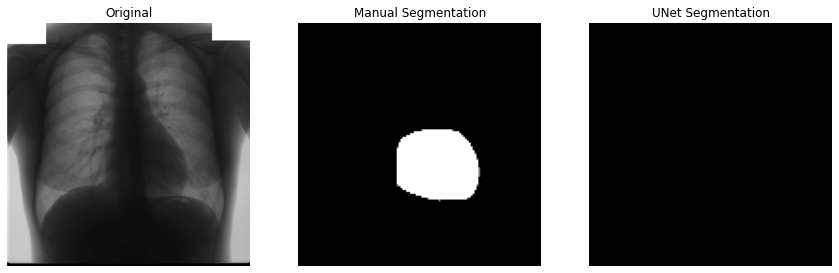

In [ ]:
# Sin BatchNorm son sólo máscaras vacías
show_results_singleclass("LN", 20, model_heart_v0, "heart")

Con BatchNorm, MSE Loss

processing file All247images/JPCLN018.IMG


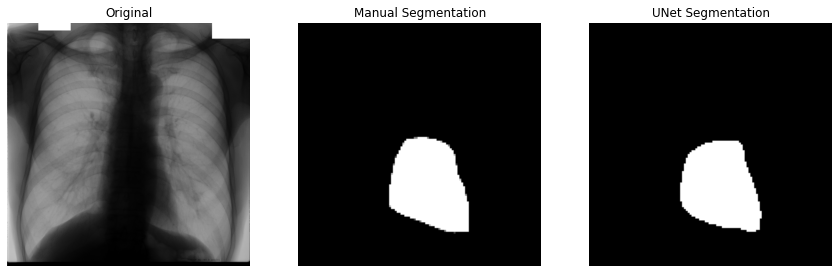

In [ ]:
show_results_singleclass("LN", 18, model_heart_v1, "heart")

Con BatchNorm, BCE Loss

processing file All247images/JPCLN026.IMG


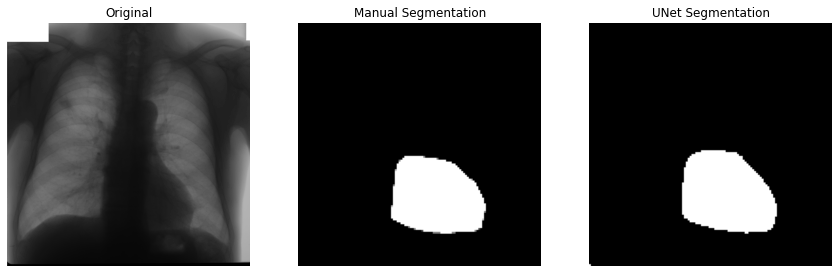

In [ ]:
show_results_singleclass("LN", 26, model_heart_v2, "heart")

Con BatchNorm, Dice Loss

processing file All247images/JPCLN084.IMG


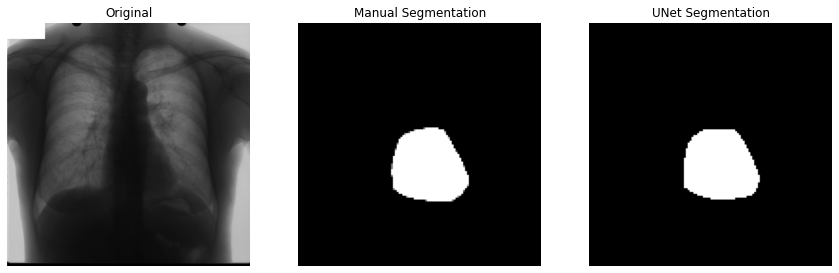

In [ ]:
show_results_singleclass("LN", 84, model_heart_v3, "heart")

#### Segmentación de Pulmones

Sin BatchNorm

processing file All247images/JPCLN026.IMG


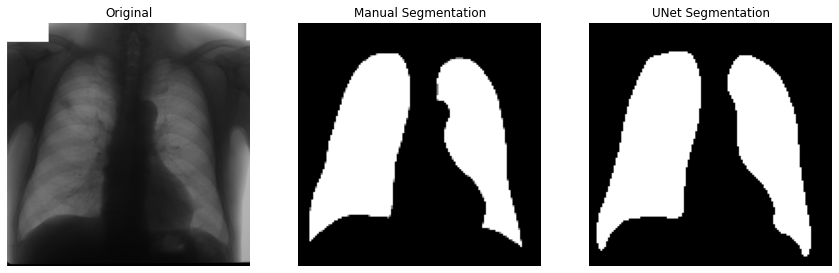

In [ ]:
show_results_singleclass("LN", 26, model_lungs_v0, "lungs")

Con BatchNorm, MSE Loss

processing file All247images/JPCLN026.IMG


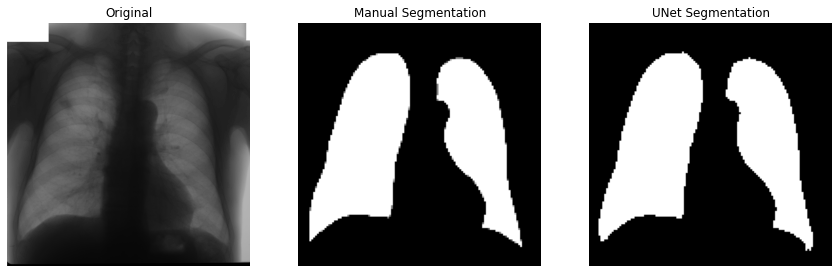

In [ ]:
show_results_singleclass("LN", 26, model_lungs_v1, "lungs")

Con BatchNorm, BCE Loss

processing file All247images/JPCLN026.IMG


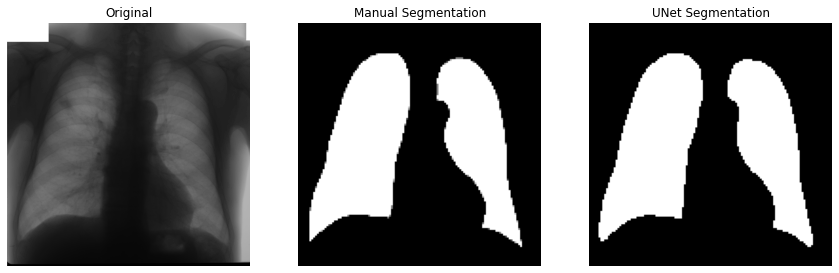

In [ ]:
show_results_singleclass("LN", 26, model_lungs_v2, "lungs")

Con BatchNorm, Dice Loss

processing file All247images/JPCLN026.IMG


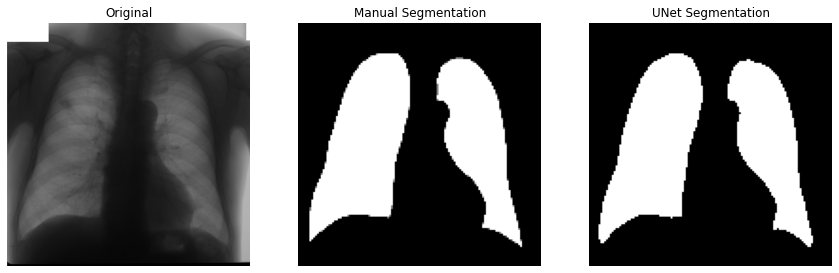

In [ ]:
show_results_singleclass("LN", 26, model_lungs_v3, "lungs")

#### Segmentación de Clavículas

Con BatchNorm, MSE Loss

processing file All247images/JPCLN020.IMG


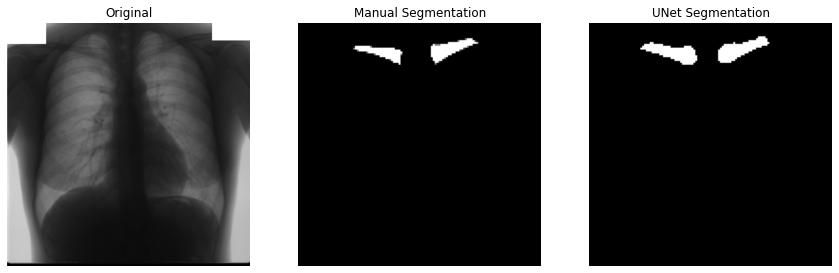

In [ ]:
show_results_singleclass("LN", 20, model_clav_v0, "clavicles")

Con BatchNorm, BCE Loss

processing file All247images/JPCLN020.IMG


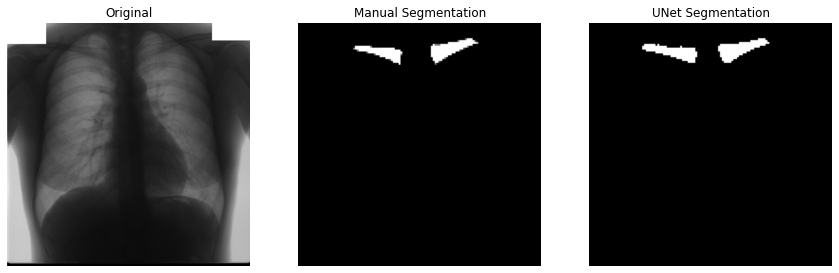

In [ ]:
show_results_singleclass("LN", 20, model_clav_v1, "clavicles")

Con BatchNorm, Dice Loss

processing file All247images/JPCLN020.IMG


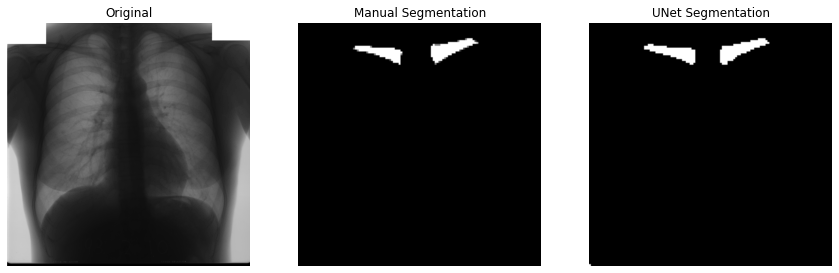

In [ ]:
show_results_singleclass("LN", 20, model_clav_v2, "clavicles")

#### Segmentación Multiclase

MSE Loss

processing file All247images/JPCLN028.IMG


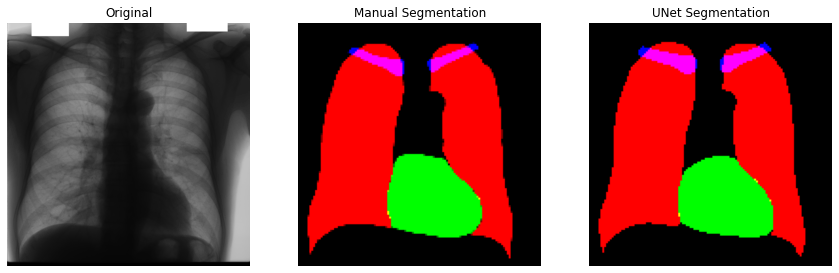

In [ ]:
show_results_multiclass("LN", 28, model_all_v0)

BCE Loss 2D

processing file All247images/JPCLN110.IMG


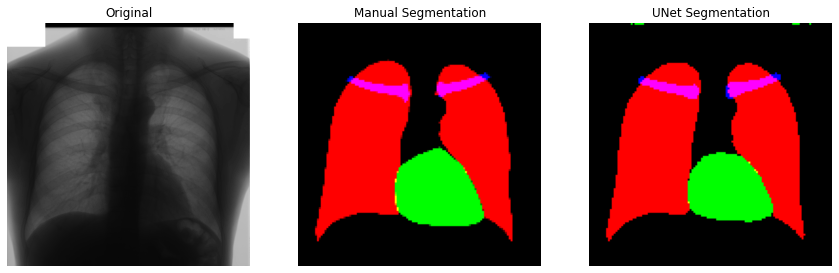

In [ ]:
show_results_multiclass("LN", 110, model_all_v1)

Dice Loss

processing file All247images/JPCLN086.IMG


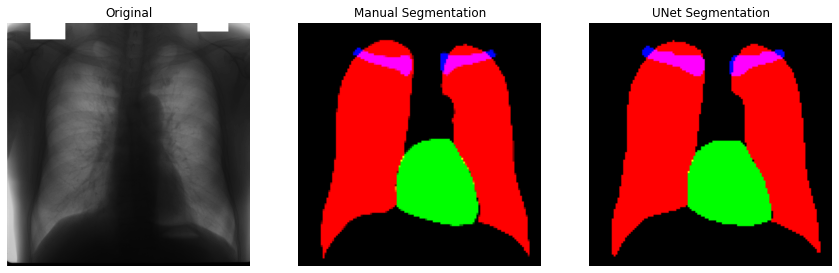

In [ ]:
show_results_multiclass("LN", 86, model_all_v2)

BCE Loss 3D

processing file All247images/JPCLN046.IMG


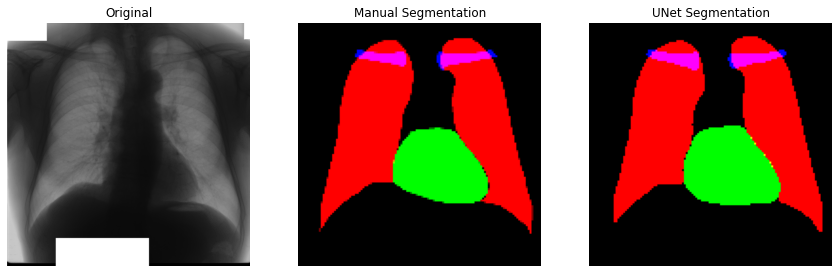

In [ ]:
show_results_multiclass("LN", 46, model_all_v3)

Log-Cosh Dice Loss

processing file All247images/JPCLN046.IMG


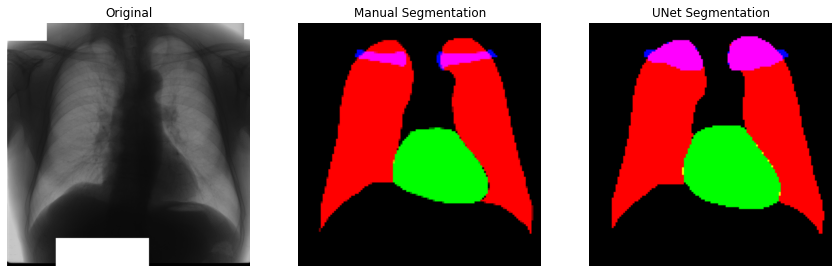

In [ ]:
show_results_multiclass("LN", 46, model_all_v4)